# Preprocessing

## Display images and FFT

In [1]:
import os
import re
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
image_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'
mask_dir = '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/masks'

In [3]:
sample_number = 11

# Validate the sample number (1-200)
if not (1 <= sample_number <= 200):
    raise ValueError("Sample number must be between 1 and 200.")

# Format the sample number as a three-digit string (e.g., 8 becomes '008')
sample_str = f"s{str(sample_number).zfill(3)}"

In [4]:
image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]
mask_filename = f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z06c1_ORG_mask.tiff"
print(image_filenames)

['Alexa488_Fibroblasts_well2_200locations_s011z01c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z02c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z03c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z04c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z05c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z06c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z07c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z08c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z09c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z10c2_ORG.tif', 'Alexa488_Fibroblasts_well2_200locations_s011z11c2_ORG.tif']


In [ ]:
image_filenames = [f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z{str(i).zfill(2)}c2_ORG.tif" for i in range(1, 12)]
mask_filename = f"Alexa488_Fibroblasts_well2_200locations_{sample_str}z06c1_ORG_mask.tiff"

# Filter for files in the directory that match the image filenames
image_files = [f for f in os.listdir(image_dir) if f in image_filenames]

magnitude = False

if len(image_files) == 0:
    print(f"No matching images found for sample {sample_str} in the specified directory.")
elif not os.path.exists(os.path.join(mask_dir, mask_filename)):
    print(f"No matching mask found for sample {sample_str} in the specified mask directory.")
elif magnitude == True:
    images_per_row = 4
    n_images = len(image_files) + 1  # Include the mask as one of the images
    n_rows = max(1, 2 * (n_images + images_per_row - 1) // images_per_row)  # Double rows for original + Spectrum
    image_files = sorted(image_files)  # Sort the images to maintain the order from z01 to z11
    
    fig, axes = plt.subplots(n_rows, images_per_row, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        
        # Display the original image
        axes[2 * idx].imshow(img, cmap="gray")
        axes[2 * idx].axis('off')
        axes[2 * idx].set_title(f"Image {idx + 1}")

        # Compute FFT and shift the zero-frequency component to the center
        img_array = np.array(img)
        fft_img = np.fft.fft2(img_array)
        fft_shifted = np.fft.fftshift(fft_img)

        # Compute magnitude spectrum and use logarithmic scale for better visibility
        magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)  # Add 1 to avoid log(0)

        # Display the magnitude spectrum
        axes[2 * idx + 1].imshow(magnitude_spectrum, cmap="gray")
        axes[2 * idx + 1].axis('off')
        axes[2 * idx + 1].set_title(f"Magnitude Spectrum {idx + 1}")

    plt.show()
else:
    images_per_row = 4
    n_images = len(image_files) + 1  # Include the mask as one of the images
    n_rows = max(1, 2 * (n_images + images_per_row - 1) // images_per_row)  # Double rows for original + Filtered FFT
    image_files = sorted(image_files)  # Sort the images to maintain the order from z01 to z11
    
    fig, axes = plt.subplots(n_rows, images_per_row, figsize=(15, n_rows * 3))
    axes = axes.flatten()

    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(image_dir, image_file)
        img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
        
        # Display the original image
        axes[2 * idx].imshow(img, cmap="gray")
        axes[2 * idx].axis('off')
        axes[2 * idx].set_title(f"Image {idx + 1}")

        # Compute and apply FFT filtering
        img_array = np.array(img)
        fft_img = np.fft.fft2(img_array)
        fft_shifted = np.fft.fftshift(fft_img)

        # Define parameters for band-stop filter
        radius = 0.001  # Adjust as needed based on the nanopillar pattern
        stop_band_width = 0.01  # Width of the band-stop area

        # Create a band-stop filter mask
        rows, cols = img_array.shape
        crow, ccol = rows // 2, cols // 2  # Center of the frequency domain

        # Initialize the mask with ones (keep all frequencies initially)
        mask = np.ones((rows, cols), dtype=np.float32)
        for x in range(rows):
            for y in range(cols):
                dist = np.sqrt((x - crow)**2 + (y - ccol)**2)
                if radius - stop_band_width < dist < radius + stop_band_width:
                    mask[x, y] = 0  # Block frequencies within the band-stop range

        # Apply the mask to the shifted FFT image
        fft_filtered = fft_shifted * mask

        # Compute the inverse FFT to obtain the filtered image
        ifft_shifted = np.fft.ifftshift(fft_filtered)
        filtered_img = np.fft.ifft2(ifft_shifted)
        filtered_img = np.abs(filtered_img)  # Take magnitude for display

        # Display the filtered image (inverse FFT result)
        axes[2 * idx + 1].imshow(filtered_img, cmap="gray")
        axes[2 * idx + 1].axis('off')
        axes[2 * idx + 1].set_title(f"Filtered Image yuhuu {idx + 1}")

    # Display the mask in the last row
    mask_path = os.path.join(mask_dir, mask_filename)
    mask_img = Image.open(mask_path)
    axes[2 * len(image_files)].imshow(mask_img, cmap="gray")
    axes[2 * len(image_files)].axis('off')
    axes[2 * len(image_files)].set_title("Mask")

    # Hide any remaining empty subplots
    for j in range(2 * len(image_files) + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations'

## Dataloader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
from pathlib import Path

ModuleNotFoundError: No module named 'torch'

In [6]:
# Setup path to data folder
data_path = Path("/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/")
image_path = data_path / "brightfield"

In [7]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 7 directories and 0 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well5_225locations'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well4_225locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well6_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well3_200locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well7_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/fo

In [8]:
random.seed(42)
image_path_list = list(image_path.glob("*/*.tif")) # * means "any combination"
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")

Random image path: /zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well2_200locations/Alexa488_Fibroblasts_well2_200locations_s088z02c2_ORG.tif
Image class: Alexa488_Fibroblasts_well2_200locations
Image height: 1024
Image width: 1024


In [9]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

mask_transform = data_transform

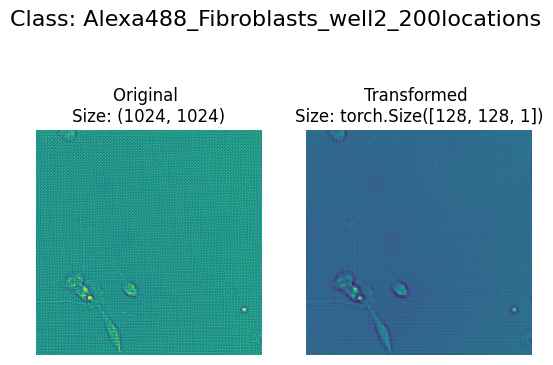

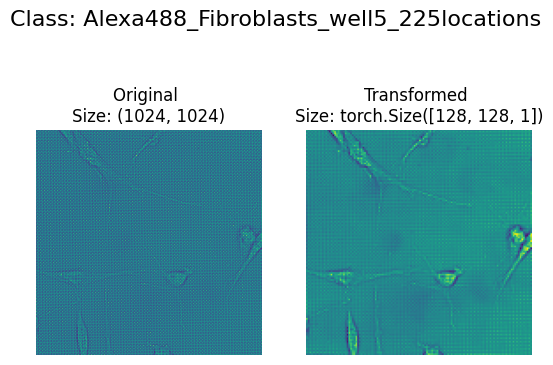

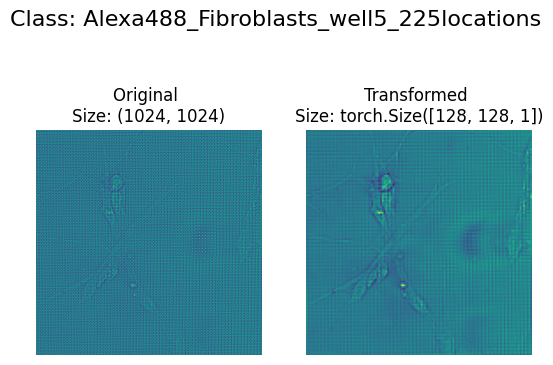

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

## Custom Dataset

In [11]:
class Well2ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        """
        Args:
            image_dir (str): Path to the directory containing images.
            mask_dir (str): Path to the directory containing masks.
            transform (callable, optional): Optional transform to be applied on an image.
            mask_transform (callable, optional): Optional transform to be applied on a mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.sample_dict = self._get_sample_dict()

    def _get_sample_dict(self):
        """
        Organize images by sample ID into a dictionary where the keys are
        sample IDs and values are lists of image file paths corresponding to each sample.
        Each key (sample ID) maps to a list of 11 image paths and 1 mask path.
        """
        sample_dict = {}
        
        # Loop through images in the directory and group by sample ID
        for filename in os.listdir(self.image_dir):
            if filename.endswith("c2_ORG.tif"):  # Filter brightfield images only
                parts = filename.split('_')
                sample_id = parts[4][:4]  # Extract 's008' as the sample ID

                # Extract the z-index using regex
                match = re.search(r'z(\d{2})', filename)
                if match:
                    z_index = match.group(1)  # Get the two-digit z-index as a string (e.g., '01')
                    z_idx = int(z_index) - 1  # Convert to integer 0-10 for list indexing

                    if sample_id not in sample_dict:
                        sample_dict[sample_id] = {'images': [None] * 11, 'mask': None}

                    sample_dict[sample_id]['images'][z_idx] = os.path.join(self.image_dir, filename)
                    #print(sample_dict[sample_id]['images'][z_idx])
                    
                    # Determine the corresponding mask path based on sample_id and z06, c1 naming convention
                    if z_index == "06":  # Only one mask for focal point z06
                        mask_filename = f"{'_'.join(parts[:3])}_200locations_{parts[4][:7]}c1_ORG_mask.tiff"
                        #print(mask_filename)
                        mask_path = os.path.join(self.mask_dir, mask_filename)
                        if os.path.exists(mask_path):
                            sample_dict[sample_id]['mask'] = mask_path
                else:
                    print(f"Warning: Could not find z-index in filename {filename}")
        
        # Filter out samples with missing images or mask
        sample_dict = {k: v for k, v in sample_dict.items() if all(v['images']) and v['mask']}
        return sample_dict

    def __len__(self):
        return len(self.sample_dict)

    def __getitem__(self, idx):
        # Retrieve sample ID and paths
        sample_id = list(self.sample_dict.keys())[idx]
        image_paths = self.sample_dict[sample_id]['images']
        mask_path = self.sample_dict[sample_id]['mask']
        
        # Load the 11 images and apply transformations
        images = []
        for img_path in image_paths:
            img = Image.open(img_path).convert("L")  # Convert to grayscale if needed
            if self.transform:
                img = self.transform(img)
            images.append(img)
        
        # Stack images along the channel dimension to create (11, H, W)
        images = torch.stack(images, dim=0)
        images = images.squeeze(1)

        # Load the mask and apply mask-specific transformations
        mask = Image.open(mask_path).convert("L")
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return images, mask  # Return both the 11-channel image stack and the mask

In [12]:
# Initialize dataset and dataloader
dataset = Well2ImageMaskDataset(image_dir=image_dir, mask_dir=mask_dir, transform=data_transform, mask_transform=mask_transform)
train_dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
print("Number of images in the dataset:", len(dataset))

# Display one sample tensor for verification
idx = random.randint(0, len(dataset) - 1)
images, mask = dataset[idx]
print("Image stack shape:", images.shape)  # Should be (11, H, W)
print("Mask shape:", mask.shape)           # Should be (1, H, W)
images

Number of images in the dataset: 196
Image stack shape: torch.Size([11, 128, 128])
Mask shape: torch.Size([1, 128, 128])


tensor([[[0.5569, 0.5843, 0.5569,  ..., 0.5961, 0.5686, 0.6157],
         [0.5804, 0.5961, 0.5922,  ..., 0.6118, 0.6196, 0.6157],
         [0.5451, 0.5804, 0.5529,  ..., 0.5922, 0.5765, 0.6118],
         ...,
         [0.5569, 0.5882, 0.5451,  ..., 0.6000, 0.5922, 0.6078],
         [0.5882, 0.5882, 0.5765,  ..., 0.5882, 0.5961, 0.5961],
         [0.5490, 0.5765, 0.5373,  ..., 0.6157, 0.6000, 0.6118]],

        [[0.5490, 0.5843, 0.5490,  ..., 0.5961, 0.5647, 0.6157],
         [0.5725, 0.5882, 0.5882,  ..., 0.6039, 0.6157, 0.6157],
         [0.5373, 0.5765, 0.5451,  ..., 0.5922, 0.5725, 0.6118],
         ...,
         [0.5569, 0.5804, 0.5412,  ..., 0.5961, 0.5882, 0.6118],
         [0.5804, 0.5922, 0.5725,  ..., 0.5882, 0.5922, 0.6000],
         [0.5451, 0.5647, 0.5333,  ..., 0.6157, 0.5961, 0.6118]],

        [[0.5451, 0.5882, 0.5490,  ..., 0.5961, 0.5647, 0.6196],
         [0.5608, 0.5804, 0.5765,  ..., 0.6000, 0.6078, 0.6118],
         [0.5294, 0.5804, 0.5412,  ..., 0.5882, 0.5686, 0.

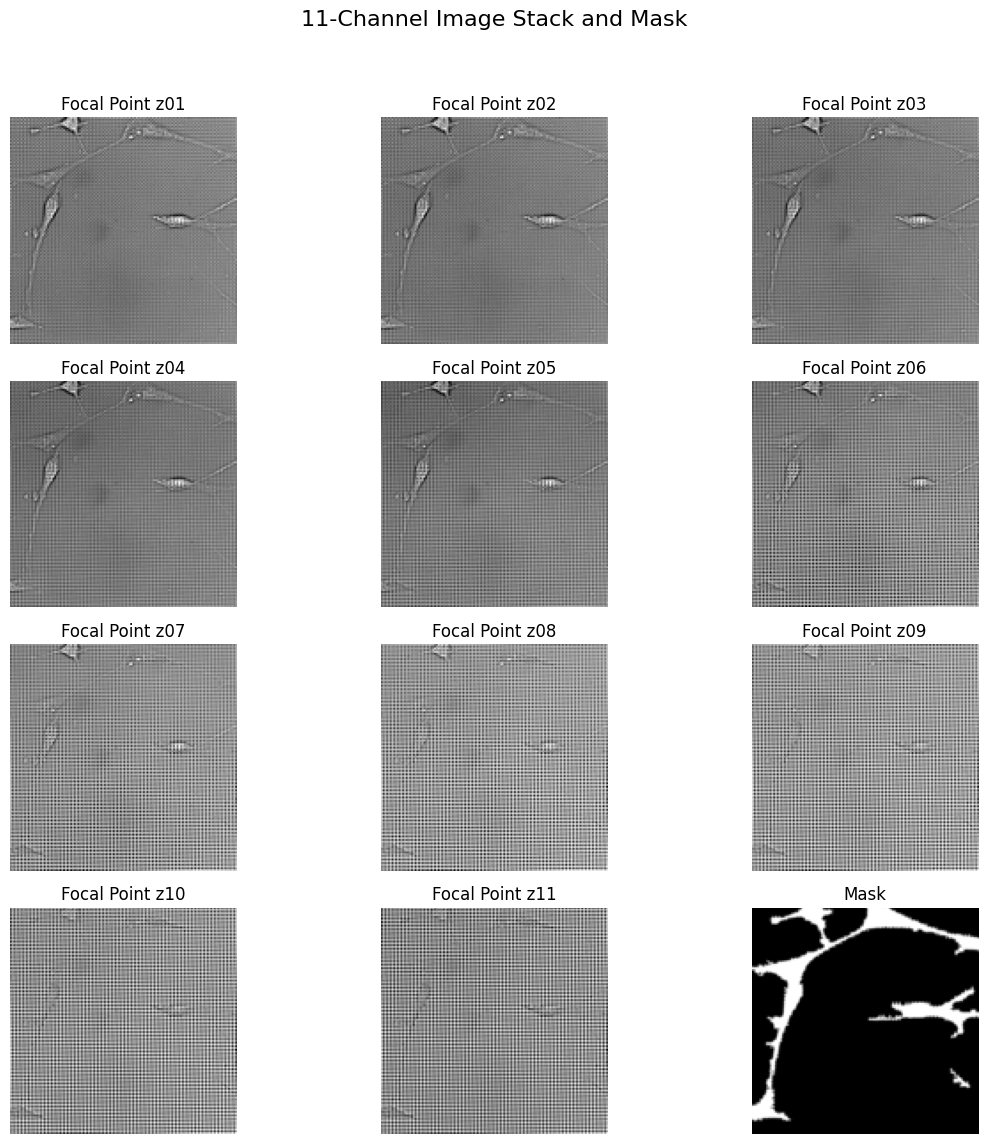

In [13]:
def display_image_stack_with_mask(images, mask):
    """
    Display each channel (focal point) in the 11-channel image stack as separate images
    and the corresponding mask in a 4x3 grid.
    
    Args:
        images (Tensor): A tensor of shape (11, H, W) representing the 11-channel image stack.
        mask (Tensor): A tensor of shape (1, H, W) representing the binary mask.
    """
    num_channels = images.shape[0]  # Should be 11 for this dataset
    
    # Create a 4x3 grid for 11 channels + 1 mask
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    fig.suptitle("11-Channel Image Stack and Mask", fontsize=16)

    for i in range(num_channels):
        # Convert each channel to numpy and remove the singleton dimension
        img_np = images[i].squeeze().numpy()  # Squeeze to shape (H, W)
        
        # Display each focal point image
        row, col = divmod(i, 3)
        axes[row, col].imshow(img_np, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Focal Point z{i + 1:02}")

    # Display the mask in the last position (row=3, col=2)
    mask_np = mask.squeeze().numpy()  # Squeeze to shape (H, W)
    axes[3, 2].imshow(mask_np, cmap='gray')
    axes[3, 2].axis('off')
    axes[3, 2].set_title("Mask")

    # Hide any unused subplots
    for j in range(num_channels + 1, 12):
        row, col = divmod(j, 3)
        axes[row, col].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title
    plt.show()

# Display a random sample from the dataset
display_image_stack_with_mask(images, mask)

# Experiment 1: Simple Segmentation Model

## Training

In [14]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [15]:
class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        
        # Downsampling (Encoder)
        self.conv1 = nn.Conv2d(11, 32, kernel_size=3, padding=1)  # Input channels: 11
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Upsampling (Decoder)
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)  # Output channels: 1 for binary mask
        
    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)  # Downsample by factor of 2
        
        # Decoder
        x = F.relu(self.upconv1(x))
        x = torch.sigmoid(self.upconv2(x))  # Sigmoid to keep output in range [0, 1]
        
        return x

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
model = SimpleSegmentationModel().to(device)  # Move model to GPU
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=3):
    model.train()  # Set model to training mode
    for epoch in range(num_epochs):
        epoch_loss = 0
        for images, masks in train_loader:
            # Move images and masks to the device (GPU if available)
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss for this batch
            epoch_loss += loss.item()

        # Average loss for this epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Train the model with the training dataloader
train_model(model, train_dataloader, criterion, optimizer, num_epochs=10)

Using device: cuda
Epoch [1/10], Loss: 0.4116
Epoch [2/10], Loss: 0.3486
Epoch [3/10], Loss: 0.3516
Epoch [4/10], Loss: 0.3486
Epoch [5/10], Loss: 0.3490
Epoch [6/10], Loss: 0.3505
Epoch [7/10], Loss: 0.3513
Epoch [8/10], Loss: 0.3487
Epoch [9/10], Loss: 0.3495
Epoch [10/10], Loss: 0.3508


## Evaluation

torch.Size([1, 128, 128])


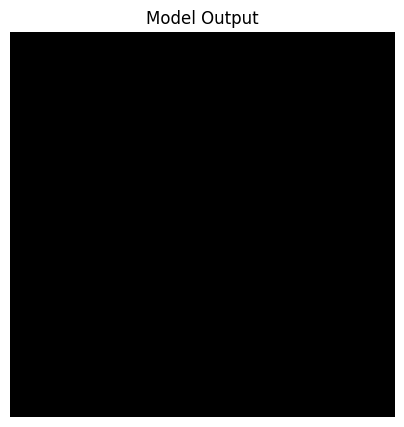

In [17]:
images, mask = dataset[idx]
images = images.to(device)

model.eval()

with torch.no_grad():  # No gradient computation needed for inference
    output = model(images)  # Forward pass

print(output.shape)
binary_output = (output > 0.5).float() # Make binary segmentation

# Move the output back to CPU and remove the batch dimension
output = binary_output.squeeze(0).cpu().numpy()  # Shape should be (1, H, W)

# Squeeze out the singleton dimension for the channel (binary mask output)
output_image = output.squeeze()

# Plot the output
plt.figure(figsize=(5, 5))
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.title("Model Output")
plt.show()

# MANUAL U-NET

U-Net is well-suited for this problem due to its skip connections, which preserve spatial details

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(11, 64)  # 11 channels to 64
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)  # 1024 from skip + upconv
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)  # 512 from skip + upconv
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)  # 256 from skip + upconv
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)  # 128 from skip + upconv
        
        # Final output layer
        self.final = nn.Conv2d(64, 1, kernel_size=1)  # Single output channel (binary mask)
        
    def conv_block(self, in_channels, out_channels):
        """Convolutional block: Conv2d -> ReLU -> Conv2d -> ReLU."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))
        
        # Decoder with skip connections
        up4 = self.upconv4(bottleneck)
        dec4 = self.dec4(torch.cat((up4, enc4), dim=1))  # Skip connection
        up3 = self.upconv3(dec4)
        dec3 = self.dec3(torch.cat((up3, enc3), dim=1))  # Skip connection
        up2 = self.upconv2(dec3)
        dec2 = self.dec2(torch.cat((up2, enc2), dim=1))  # Skip connection
        up1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((up1, enc1), dim=1))  # Skip connection
        
        # Final output
        return torch.sigmoid(self.final(dec1))  # Output in range [0, 1]

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
print(f"Using device: {device}")

# Loss and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop remains the same as your SimpleSegmentationModel


In [ ]:
import torch

# Assume the U-Net class is already defined
# Initialize the U-Net model
model = UNet().to(device)  # Use the manual U-Net implementation
model.eval()  # Set to evaluation mode

# Create a fake input tensor
batch_size = 1  # Simulate one image in the batch
input_channels = 11  # Corresponds to the 11 focal planes
height, width = 128, 128  # Image dimensions

# Generate a fake tensor with random values
fake_input = torch.rand(batch_size, input_channels, height, width).to(device)

# Pass the fake data through the model
with torch.no_grad():  # Disable gradient computation for testing
    output = model(fake_input)

# Print the output shape
print(f"Input shape: {fake_input.shape}")
print(f"Output shape: {output.shape}")

# Verify output dimensions
assert output.shape == (batch_size, 1, height, width), "Output dimensions are incorrect!"

# Optionally, visualize the output (single channel binary mask)
import matplotlib.pyplot as plt

# Move output to CPU and remove batch dimension
output_image = output.squeeze(0).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Plot the output
plt.figure(figsize=(5, 5))
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.title("Fake Output")
plt.show()

# PRETRAINED U-NET

In [ ]:
import segmentation_models_pytorch as smp
import torch.nn as nn

# Load pretrained U-Net with a ResNet backbone
pretrained_unet = smp.Unet(
    encoder_name="resnet34",        # Choose a ResNet backbone (others available)
    encoder_weights="imagenet",    # Use pretrained weights on ImageNet
    in_channels=3,                 # Placeholder for in_channels, will replace later
    classes=1                      # Output channels (binary mask)
)

# Modify the first convolutional layer to accept 11 input channels
pretrained_unet.encoder.conv1 = nn.Conv2d(
    in_channels=11,               # From 3 to 11 channels
    out_channels=64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

# Optional: Initialize weights for the modified layer
nn.init.kaiming_normal_(pretrained_unet.encoder.conv1.weight, mode='fan_out', nonlinearity='relu')

# Move to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_unet = pretrained_unet.to(device)
